<a href="https://colab.research.google.com/github/kapilgeet123/Whatsapp/blob/master/GOT_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Here is a R-based 'get started' document to analyse this Game of Thrones (GoT) Twitter data set. We will look into

- US-wide geographical distribution of users
- Co-occurrence of names from key GoT characters
- Time-resolved popularity of individual characters

Firstly, you will need to load the relevant packages and read the `gotTwitter.csv` file.

In [ ]:
# Load libraries
library(tidyverse)
library(reshape2)
library(ggplot2)
library(ggridges)
library(lubridate)
library(rtweet)
library(maps)
library(quanteda)
library(quanteda.textplots)

# Read final dataset
allTweets <- read_twitter_csv("/content/sample_data/gotTwitter.csv", unflatten = T)

In [ ]:
install.packages("quanteda.textplots")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘coda’, ‘extrafontdb’, ‘Rttf2pt1’, ‘statnet.common’, ‘extrafont’, ‘ggrepel’, ‘sna’, ‘igraph’, ‘network’




Next, convert and overwrite UTC time at column `created_at` to EDT (NY time) and check out the user US-wide geographical distribution using the `maps` package.

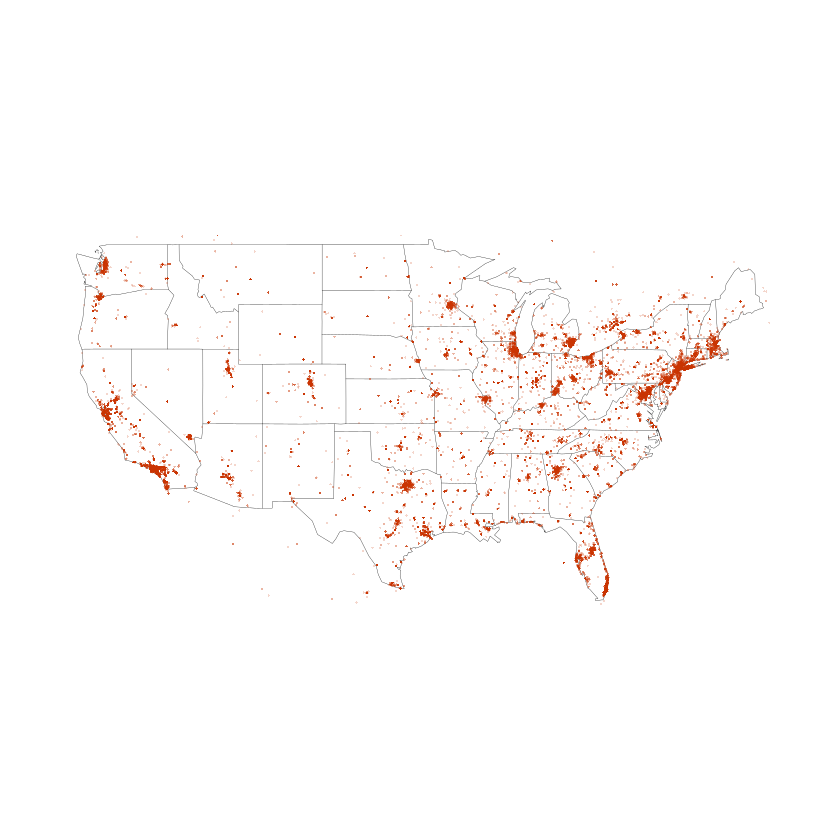

In [ ]:
# Convert UTC to EDT
allTweets %<>% dplyr::mutate(created_at = as_datetime(created_at, tz = "UTC")) %>% 
      dplyr::mutate(created_at = with_tz(created_at, tzone = "America/New_York"))

# Produce lat and lng coordinates
allTweets <- lat_lng(allTweets)
# Plot
par(mar = rep(12, 4))
map("state", lwd = .25)
# plot lat and lng points onto state map
with(allTweets, points(lng, lat,
                       pch = 16, cex = .25,
                       col = rgb(.8, .2, 0, .2)))

Clearly most of the US and certain Canadian and Mexican locations were identified. Next up we will be using the `quanteda` package to tokenize the actual tweets under the column `text` and clean them by stripping out Twitter tags, separators, symbols, punctuation, URLs, hyphens and numbers. The last step generates all *n*-grams of size one and two, the latter being instrumental to identify Grey Worm and Night King. From these tokens we generate a document-feature matrix (DFM) and select entries that match the names of 20 GoT characters of my choice. Finally, we derive a feature co-occurrence matrix (FCM) and visualize the resulting character associations in a weighted network. Some associations should be obvious to GoT fans!

Warning message:
“remove_twitter, remove_hyphens arguments are not used.”
Warning message:
“'remove' is deprecated; use dfm_remove() instead”


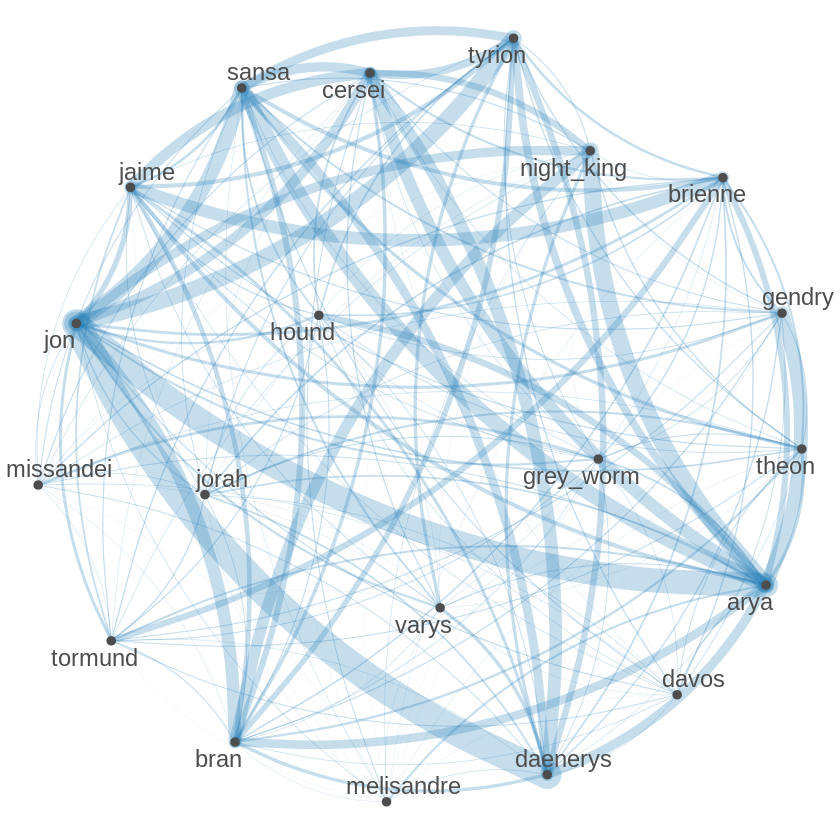

In [ ]:
# Tokenize words
tkn <- tokens(allTweets$text,
              remove_twitter = T,
              remove_separators = T,
              remove_symbols = T,
              remove_punct = T,
              remove_url = T,
              remove_hyphens = T,
              remove_numbers = T) %>% 
      tokens_ngrams(n = 1:2)

gotDfm <- dfm(tkn, tolower = T,
              remove = stopwords("english"))

gotChars <- c("jon", "cersei", "sansa", "arya",
              "bran", "tyrion", "jaime", "daenerys",
              "hound", "davos", "missandei", "theon",
              "brienne", "gendry", "grey_worm", "jorah",
              "night_king", "varys", "melisandre", "tormund")

gotFcm <- dfm_select(gotDfm, pattern = gotChars) %>% 
      fcm()

set.seed(100)
library("quanteda")
textplot_network(gotFcm, min_freq = 0.1,
                 edge_alpha = .25,
                 edge_size = 5)

Among the strongest associations are the couples Jon/Daenerys, Brienne/Jaime and Gendry/Arya, and also the Arya/Night King duel. Finally, we will examine the time-resolved popularity of the individual characters framed against the air dates of all six episodes. This analysis will come straight out of our tokenized object above.

Picking joint bandwidth of 337000



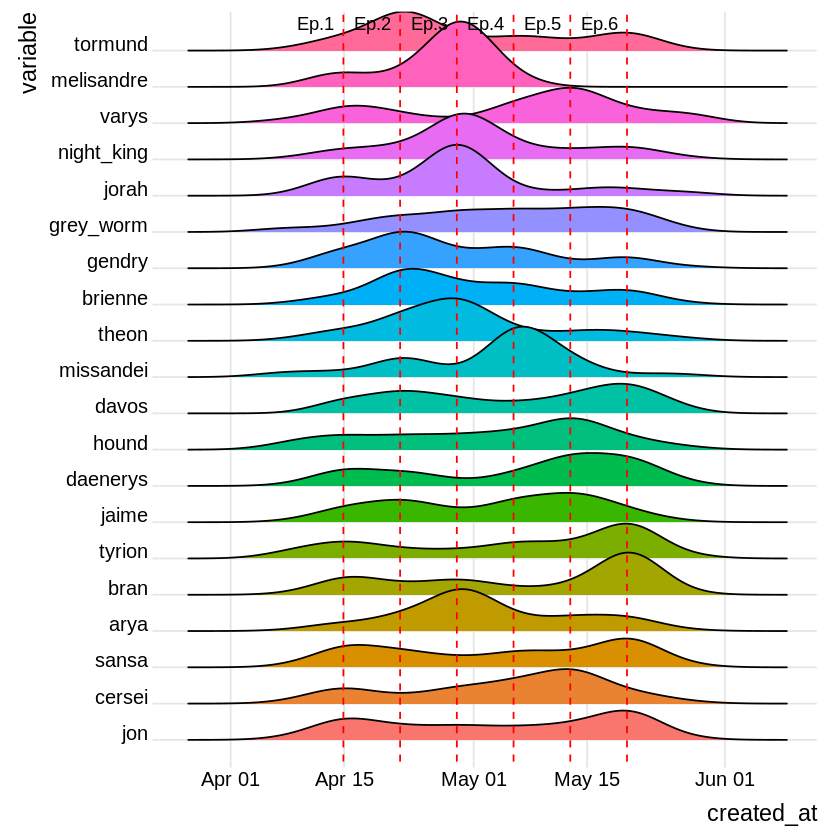

In [ ]:
# Identify tweets containing any of the characters names (0/1)
popularity <- as.data.frame(lapply(gotChars, function(x){
      as.integer(sapply(tkn, function(k){any(k %in% x)}))
}))

# Write colnames
colnames(popularity) <- gotChars

# Add column with corresponding EST time
popularity$created_at <- allTweets$created_at

# Reshape w.r.t. created_at, select hits
popularity <- reshape2::melt(popularity, id.vars = "created_at")
popularity <- slice(popularity, which(value == 1))

# Determine the time all six episodes were aired (9pm EST every Sunday starting 14th April)
epAirTime  <- ymd_hms("2019-04-14 21:00:00",tz="EST") + dweeks(0:5)

# Plot ggridge-style
ggplot(popularity, aes(x = created_at, y = variable, fill = variable)) + 
      geom_density_ridges() +
      geom_vline(xintercept = epAirTime, linetype = "dashed",
                 color = "red",show.legend = T) +
      theme_ridges() + 
      theme(legend.position = "none") +
      annotate("text", x = epAirTime, y = 20.75,
               label = paste0("Ep.", c(1:6)) ,hjust = 1.25) 

Here too, the results should make sense to fans. Among other things,

- Brienne was knighted by Jaime in Ep. 2
- Arya killed the Night King in Ep. 3
- Jorah, Melisandre and Theon all died in Ep. 3
- Missandei was beheaded in Ep. 4
- Bran became king in Ep. 6



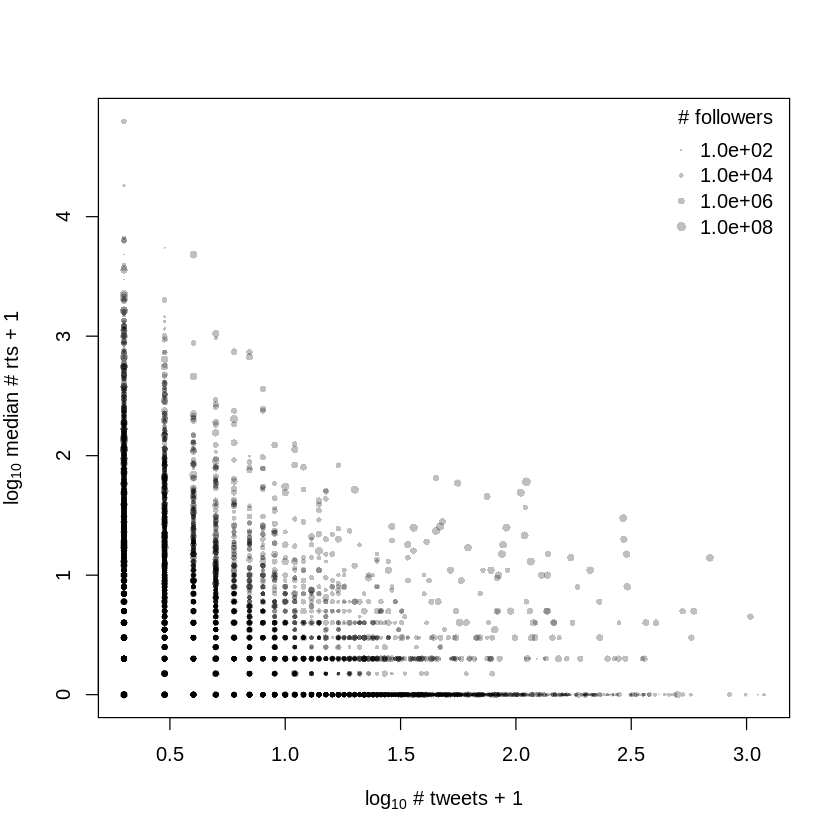

In [ ]:
rtStats <- do.call("rbind", by(allTweets, INDICES = allTweets$screen_name, function(x){
      return(data.frame(num_tweets = nrow(x),
                        mean_followers = mean(x$followers_count),
                        median_rt = median(x$retweet_count)))        
}))

# Plot log10(num_tweets) vs. log10(median_rt)
with(log10(rtStats+1), plot(num_tweets, median_rt,
                            cex = mean_followers / max(mean_followers),
                            pch = 16,
                            col = rgb(0,0,0,.25),
                            xlab = expression(paste(log[10], " # tweets + 1")),
                            ylab = expression(paste(log[10], " median # rts + 1"))))
nums <- c(1e2, 1e4, 1e6, 1e8)
legend("topright", title = "# followers",
       pch = 16, col = rgb(0,0,0,.25),
       pt.cex = log10(nums + 1)/max(log10(rtStats$mean_followers + 1)),
       legend = formatC(nums, format = "e", digits = 1),
       bty = "n")

Warning message:
“remove_twitter, remove_hyphens arguments are not used.”
Warning message:
“'remove' is deprecated; use dfm_remove() instead”
Warning message:
“'stem' is deprecated; use dfm_wordstem() instead”


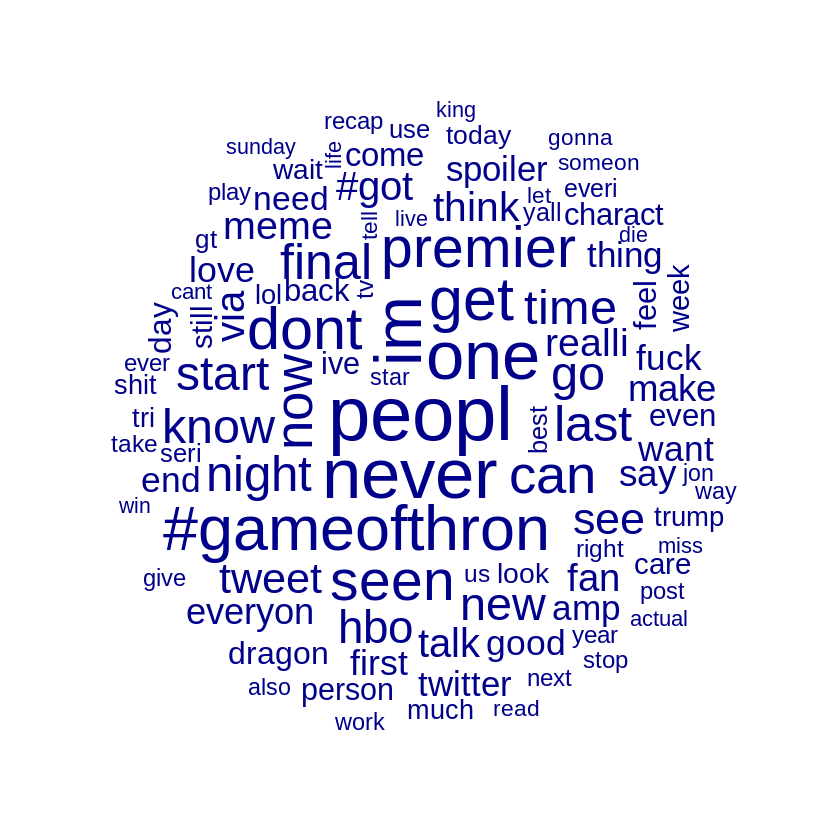

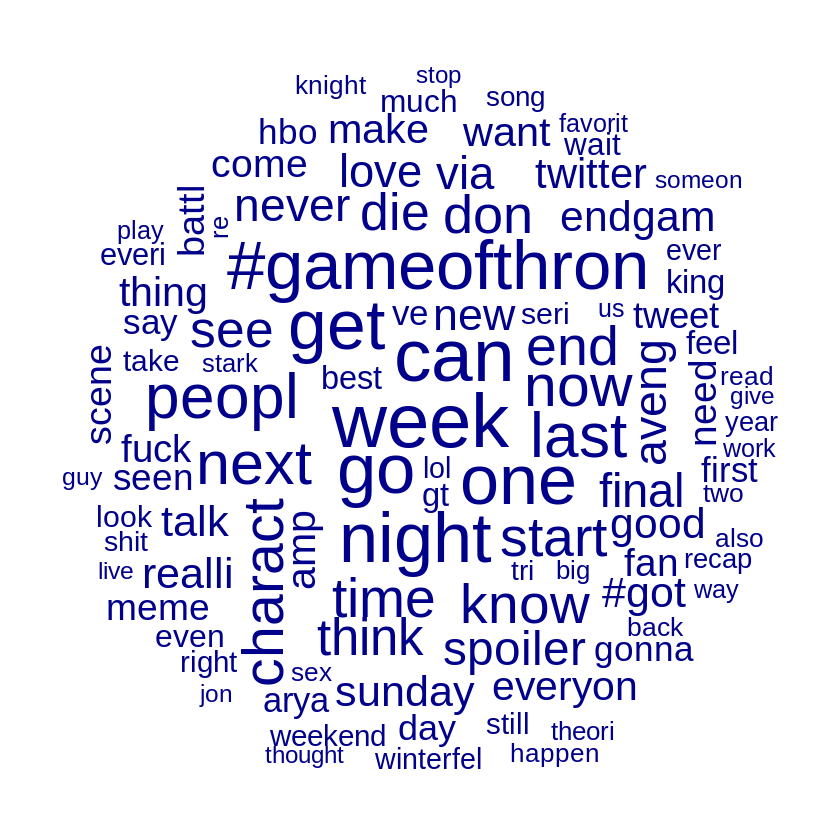

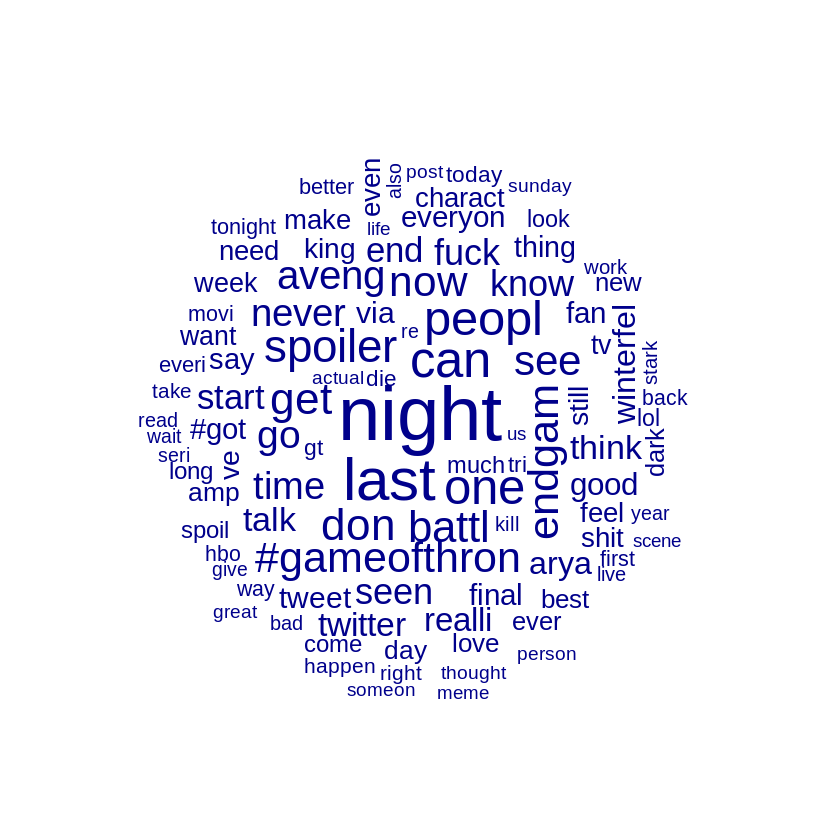

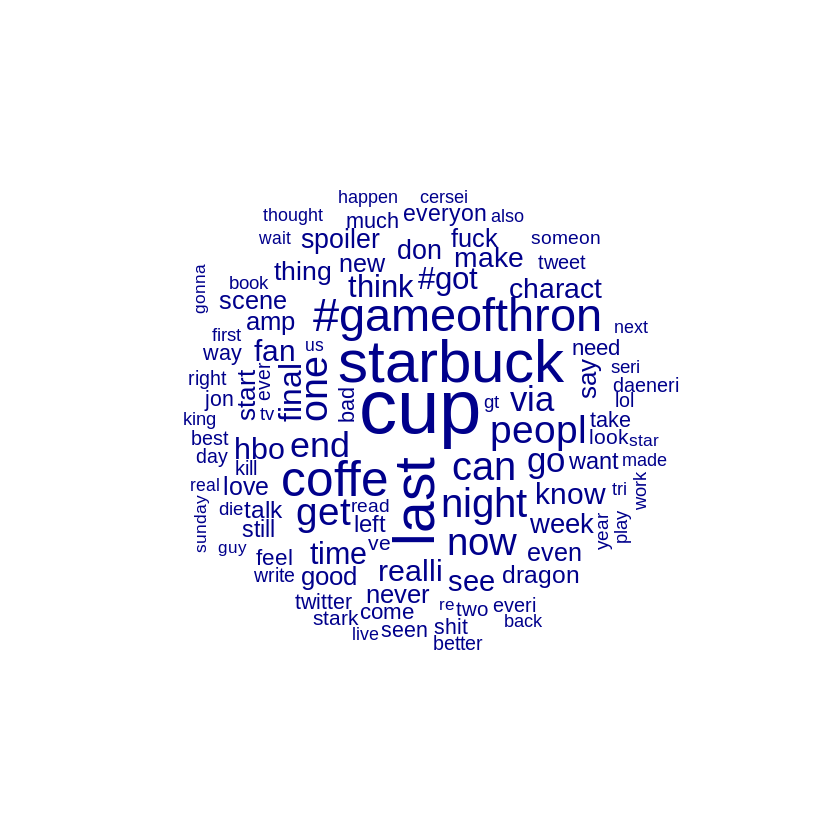

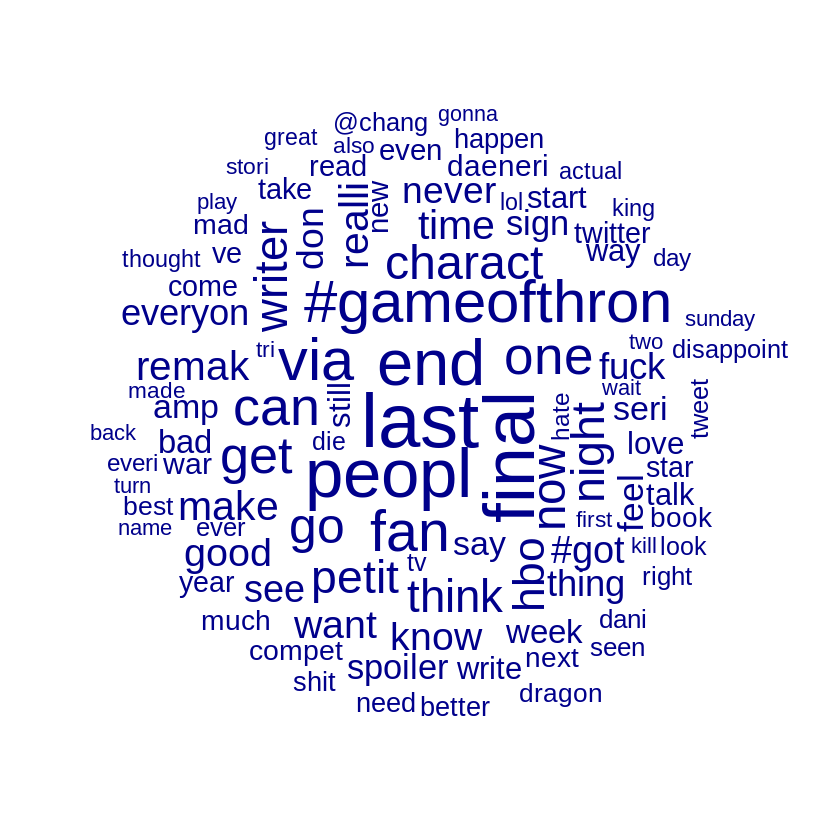

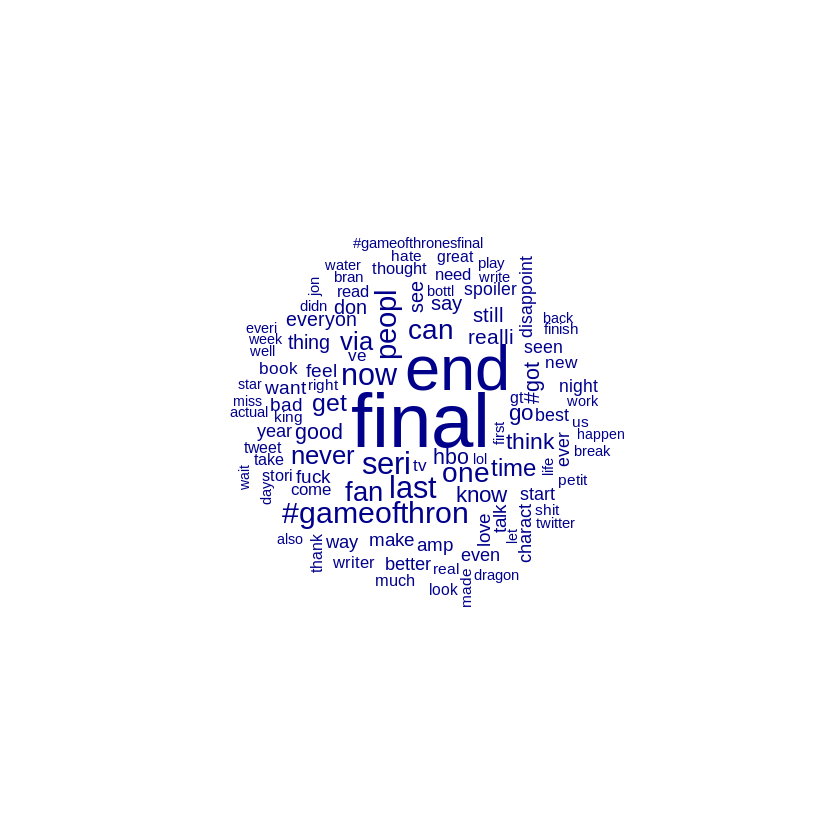

In [ ]:
# Wordcloud 
# Remove potential bots w/ > 100 tweets in the dataset
bots <- rownames(rtStats)[which(rtStats$num_tweets > 100)]
reducedTweet <- allTweets[!allTweets$screen_name %in% bots,]
# reducedTweet$text <- texts(reducedTweet$text) %>% 
#       iconv(from = "UTF-8", to = "ASCII", sub = "") %>% 
#       gsub(pattern = "<[A-Z+0-9]+>", repl = " ")
reducedTweet$text <- iconv(reducedTweet$text, from = "UTF-8", to = "ASCII", sub = "")
reducedTweet$text <- gsub(reducedTweet$text, pattern = "<[A-Z+0-9]+>", repl = " ")
# reducedTweet$text <- texts(reducedTweet$text)
# Tokenize words
tkn <- tokens(reducedTweet$text,
              remove_twitter = T,
              remove_separators = T,
              remove_symbols = T,
              remove_punct = T,
              remove_url = T,
              remove_hyphens = T,
              remove_numbers = T)

# Remove stopwords and stem words
gotDfm <- dfm(tkn, tolower = T, 
              remove = stopwords("en"),
              stem = T)

# Remove irrelevant terms incl. single-character words
badWords <- c("game", "throne", "gameofthron", "got",
              "watch", "episod", "season", "show",
              "just", "like")
gotDfm <- gotDfm[,nchar(colnames(gotDfm)) > 1 &
                 !colnames(gotDfm) %in% badWords]

epAirTime  <- ymd_hms("2019-04-14 21:00:00", tz = "EST") + dweeks(0:5)
wcLists <- lapply(1:6, function(x){
      idx <- reducedTweet$created_at > epAirTime[x] + dhours(2) &
            reducedTweet$created_at < epAirTime[x] + ddays(4)
      return(gotDfm[idx,])
})

par(mar = rep(0, 4))
for(i in 1:length(wcLists)){
      set.seed(100)
      textplot_wordcloud(wcLists[[i]],
                         max_words = 100)        
}

Warning message:
“'remove' is deprecated; use dfm_remove() instead”
Warning message:
“'stem' is deprecated; use dfm_wordstem() instead”


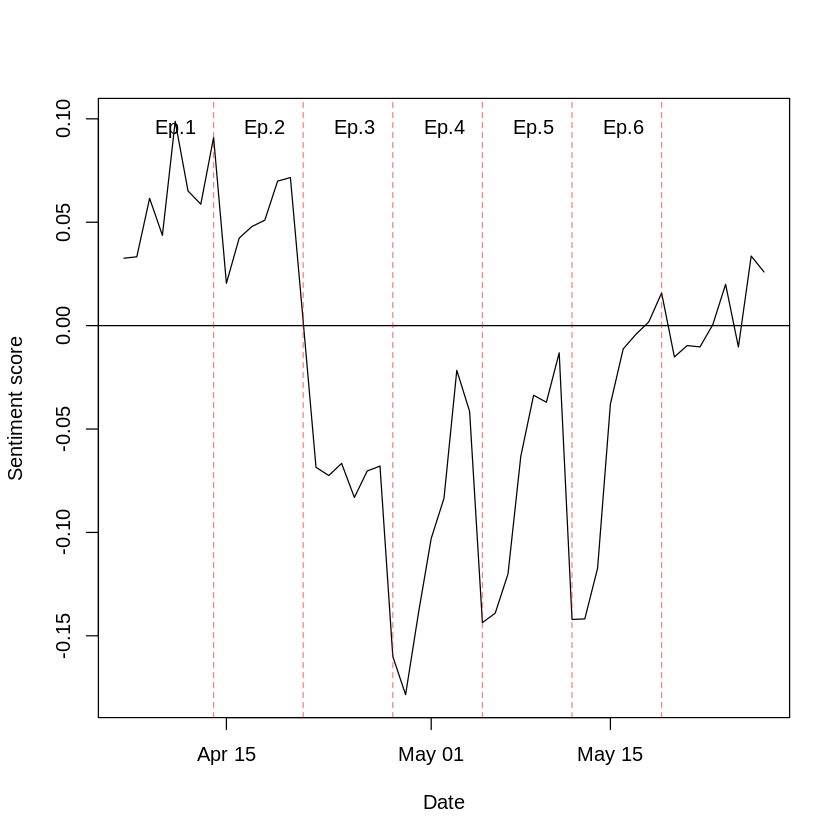

In [ ]:
# Sentiment analysis
tknDct <- tokens_lookup(tkn, dictionary = data_dictionary_LSD2015)
saDfm <- dfm(tknDct,
             remove = stopwords("en"),
             stem = T)

summ <- do.call("rbind", by(convert(saDfm, to="data.frame")[,-1],
                            INDICES = date(reducedTweet$created_at),
                            FUN = colSums))
plot(date(rownames(summ)),
     (summ[,2] - summ[,1]) / rowSums(summ[,1:2]),
     type = "l", xlab = "Date", ylab = "Sentiment score")
abline(h = 0)
abline(v = date(epAirTime), lty = 2, col = rgb(1,0,0,.5))
text(date(epAirTime) - 3, .095, labels = paste0("Ep.", c(1:6)))